In [ ]:
! pip install -q "datasets==2.20.0" flash_attn "timm==1.0.7" "einops==0.8.0" "transformers==4.42.3" pillow huggingface_hub

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [3]:
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoProcessor
import torch
import os
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.data import Dataset
import requests
from PIL import Image

In [4]:
# Load the dataset in streaming mode for trainig
dataset = load_dataset("HuggingFaceM4/DocumentVQA", split='train', streaming=True)

# Convert the streaming dataset to a list of dictionaries and take only the first 1000 records
train_data = list(dataset.take(1000))

print(train_data[0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

{'questionId': 337, 'question': 'what is the date mentioned in this letter?', 'question_types': ['handwritten', 'form'], 'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=1695x2025 at 0x79AA30385690>, 'docId': 279, 'ucsf_document_id': 'xnbl0037', 'ucsf_document_page_no': '1', 'answers': ['1/8/93']}


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model

In [ ]:
model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True, revision='refs/pr/6').to(device)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True, revision='refs/pr/6')
torch.cuda.empty_cache()

# Before Training the Model

Test the base model

In [7]:
def run_example(task_prompt, text_input, image):
    prompt = task_prompt + text_input

    # Ensure the image is in RGB mode
    if image.mode != "RGB":
        image = image.convert("RGB")

    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))
    return parsed_answer

for idx in range(3):
  print(run_example("DocVQA", 'What do you see in this image?', train_data[idx]['image']))


{'DocVQA': 'unanswerable'}
{'DocVQA': 'unanswerable'}
{'DocVQA': '499150498'}


In [8]:
# url = "https://marketplace.canva.com/EAFXqL8NfTQ/1/0/1131w/canva-black-%26-orange-a4-professional-invoice-ZAbveYe41E8.jpg"
url = "https://templates.invoicehome.com/invoice-template-us-dexter-750px.png"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
run_example("DocVQA", 'What is the unit price of "front and rear brake cables"?', image)

{'DocVQA': 'unanswerable'}

# Dataset Preparation

In [9]:
# Load the dataset in streaming mode for validation
validation_dataset = load_dataset("HuggingFaceM4/DocumentVQA", split='validation', streaming=True)

# Convert the streaming dataset to a list of dictionaries and take only the first 100 records
val_data = list(validation_dataset.take(100))

print(val_data[0])

Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

{'questionId': 49153, 'question': 'What is the ‘actual’ value per 1000, during the year 1975?', 'question_types': ['figure/diagram'], 'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=2257x1764 at 0x79AA19C0A4A0>, 'docId': 14465, 'ucsf_document_id': 'pybv0228', 'ucsf_document_page_no': '81', 'answers': ['0.28']}


In [10]:
class DocVQADataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        question = "<DocVQA>" + example['question']
        first_answer = example['answers'][0]
        image = example['image']
        if image.mode != "RGB":
            image = image.convert("RGB")
        return question, first_answer, image

train_dataset = DocVQADataset(train_data)
val_dataset = DocVQADataset(val_data)

In [11]:
def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(device)
    return inputs, answers

batch_size = 2
num_workers = 0
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=num_workers)

# Train Model

In [12]:
from transformers import AdamW, AutoProcessor, get_scheduler

In [13]:
def train_model(train_loader, val_loader, model, processor, epochs=5, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        i = -1
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            i += 1
            inputs, answers = batch

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
                inputs, answers = batch

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Average Validation Loss: {avg_val_loss}")

        # Save model checkpoint
        output_dir = f"./model_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)

In [14]:
for param in model.vision_tower.parameters():
  param.is_trainable = False

train_model(train_loader, val_loader, model, processor)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1/5: 100%|██████████| 500/500 [11:50<00:00,  1.42s/it]


Average Training Loss: 3.7525856072306634


Validation Epoch 1/5: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Average Validation Loss: 2.3586427453160286


Training Epoch 2/5: 100%|██████████| 500/500 [11:40<00:00,  1.40s/it]


Average Training Loss: 2.2911871649622917


Validation Epoch 2/5: 100%|██████████| 50/50 [00:26<00:00,  1.87it/s]


Average Validation Loss: 1.7490375092625619


Training Epoch 3/5: 100%|██████████| 500/500 [11:44<00:00,  1.41s/it]


Average Training Loss: 1.6892534320503474


Validation Epoch 3/5: 100%|██████████| 50/50 [00:27<00:00,  1.85it/s]


Average Validation Loss: 1.523611726462841


Training Epoch 4/5: 100%|██████████| 500/500 [11:39<00:00,  1.40s/it]


Average Training Loss: 1.3985311063081025


Validation Epoch 4/5: 100%|██████████| 50/50 [00:26<00:00,  1.86it/s]


Average Validation Loss: 1.475408730506897


Training Epoch 5/5: 100%|██████████| 500/500 [11:38<00:00,  1.40s/it]


Average Training Loss: 1.2829639354795217


Validation Epoch 5/5: 100%|██████████| 50/50 [00:26<00:00,  1.86it/s]


Average Validation Loss: 1.4584522821009158


# Evaluation

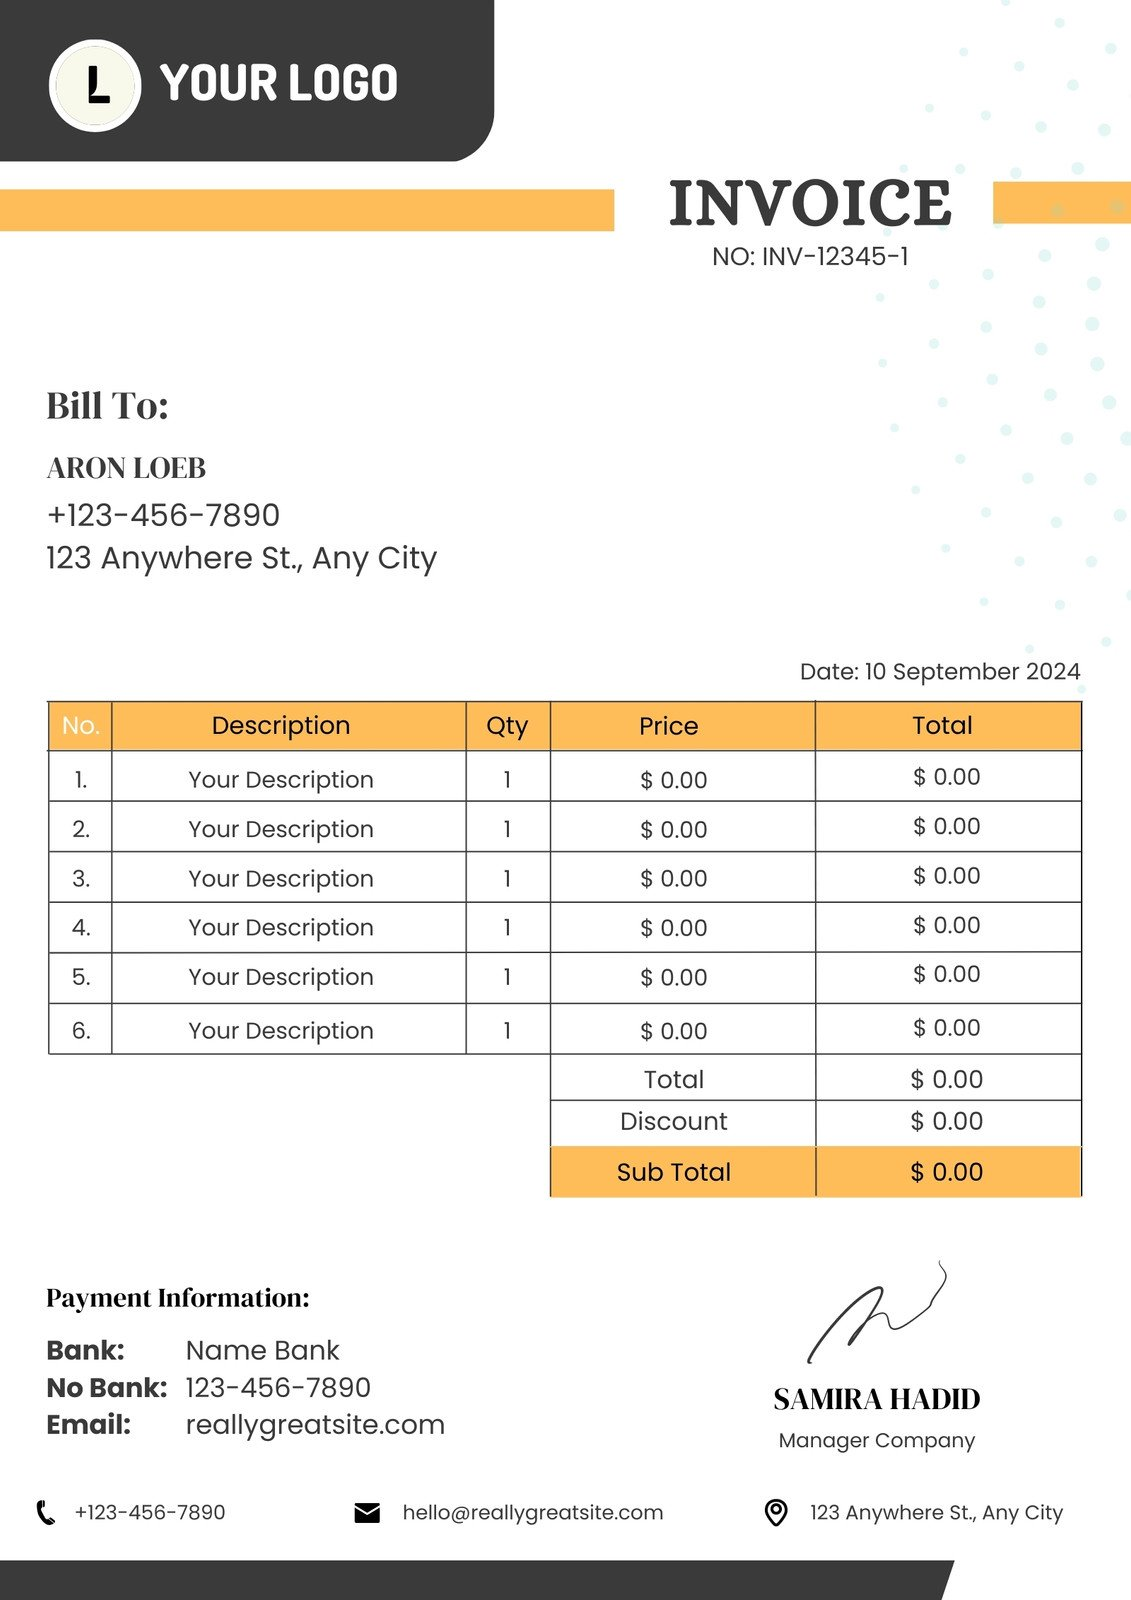

In [15]:
url = "https://marketplace.canva.com/EAFXqL8NfTQ/1/0/1131w/canva-black-%26-orange-a4-professional-invoice-ZAbveYe41E8.jpg"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
image

In [16]:
run_example("DocVQA", 'What is the email address?', image)

{'DocVQA': 'reallygreatsite.com'}

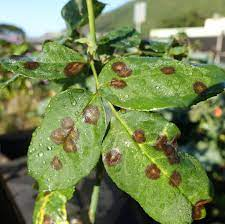

In [17]:
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRYoDmTW0JLiW2VNGbT0OozJqi3biTszTOQKCnuuvdPuFUzHS6gQwFdCLQi7mmY7hGD150&usqp=CAU"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
image

In [18]:
run_example("DocVQA", 'What is the diseases of this leaf?', image)

{'DocVQA': 'dandelion'}

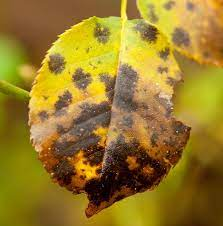

In [19]:
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRySzFhYy_aPvzvGMqzLP8RQ-F0Tf5lDmQ8dI82HIgVJQHltwvY6wP2NLHumcAxrHEzJlA&usqp=CAU"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
image

In [20]:
run_example("DocVQA", 'What is the diseases of this leaf?', image)

{'DocVQA': 'dirt'}

In [21]:
url = "https://templates.invoicehome.com/invoice-template-us-dexter-750px.png"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
run_example("DocVQA", 'What is the unit price of "front and rear brake cables"?', image)

{'DocVQA': '100.00'}

# Push fine-tuned model to hub

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
repo_name = "Florence-2_FT_VQA"

model.push_to_hub(repo_name,
                  safe_serialization=True,
                  commit_message="fine tuned florence-2 model",
                  private=True,
                  )

processor.push_to_hub(repo_name, private=True)